### CMPE 256 Class Presentation - VAR Commodity Pricing Model - Gold & Silver ###
###### Covers: Book Topics: Machine Learning and Artificial Intelligence for Agricultural Economics: Prognostic Data Analytics to Serve Small Scale Farmers Worldwide, Publisher :  Springer; 1st ed. 2021 edition (October 5, 2021), ISBN-13: 978-3030774844 ######

https://towardsdatascience.com/granger-causality-and-vector-auto-regressive-model-for-time-series-forecasting-3226a64889a6

***FORECASTING of Gold and Oil*** have garnered major attention from academics, investors and Government agencies like. These two products are known for their substantial influence on global economy. I will show here, how to use Granger’s Causality Test to test the relationships of multiple variables in the time series and Vector Auto Regressive Model (VAR) to forecast the future Gold & Oil prices from the historical data of ***Gold prices, Silver prices, Crude Oil prices, Stock index , Interest Rate and USD rate***.

https://www.lbma.org.uk/prices-and-data/precious-metal-prices#/
https://fred.stlouisfed.org/series/FEDFUNDS

In [1]:
import logging
import pandas as pd
import numpy as np
from numpy import random
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import re
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import scipy.stats as spstats
import seaborn as sns


%matplotlib inline
mpl.style.reload_library()
mpl.style.use('classic')
mpl.rcParams['figure.facecolor'] = (1, 1, 1, 0)
mpl.rcParams['figure.figsize'] = [6.0, 4.0]
mpl.rcParams['figure.dpi'] = 40

In [2]:
! pip install seaborn

In [3]:
from google.colab import files
uploaded = files.upload()

Saving DCOILWTICO_2022-03-31.csv to DCOILWTICO_2022-03-31.csv
Saving DGS10.csv to DGS10.csv
Saving FEDFUNDS_2022-03-31.csv to FEDFUNDS_2022-03-31.csv
Saving lbma_gold_am_usd_1967-12-31_2022-03-31.csv to lbma_gold_am_usd_1967-12-31_2022-03-31.csv
Saving lbma_silver_am_usd_1967-12-31_2022-03-31.csv to lbma_silver_am_usd_1967-12-31_2022-03-31.csv
Saving SPIndex_2022-03-31.csv to SPIndex_2022-03-31.csv


<H1> Gold Dataset </H1> <H3> Load Glod Dataset and set Date as Index. </H3>

In [9]:
#Gold price data
goldDF = pd.read_csv("/content/lbma_gold_am_usd_1967-12-31_2022-03-31.csv",parse_dates=['Date'], dayfirst=True)
goldDF = goldDF.set_index('Date')
goldDF.head()


<ipython-input-9-57de0582e788>:2: UserWarning: Parsing dates in %m/%d/%Y format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  goldDF = pd.read_csv("/content/lbma_gold_am_usd_1967-12-31_2022-03-31.csv",parse_dates=['Date'], dayfirst=True)


GoldPrice
Date                 
2022-03-31    1924.10
2022-03-30    1917.80
2022-03-29    1911.05
2022-03-28    1927.00
2022-03-25    1956.65

<h3> Check for nulls </H3>

In [10]:
goldDF.isnull().sum() ## missing values

GoldPrice    0
dtype: int64

In [11]:
goldDF.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 13712 entries, 2022-03-31 to 1968-01-02
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   GoldPrice  13712 non-null  float64
dtypes: float64(1)
memory usage: 214.2 KB


In [12]:
goldDF.columns

Index(['GoldPrice'], dtype='object')

Text(0, 0.5, 'Frequency')

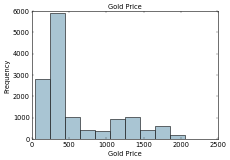

In [13]:

fig, ax = plt.subplots()
goldDF['GoldPrice'].hist(color='#A9C5D3', edgecolor='black',
                          grid=False)
ax.set_title('Gold Price', fontsize=12)
ax.set_xlabel('Gold Price', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)

<h5> Create Gold Price Bins - divide price into five quantiles (0, 25%, 50%, 75%, and 100%) </h5>

In [14]:
goldDF['GoldPrice_bin_round'] = np.array(np.floor(
                              np.array(goldDF['GoldPrice']) / 10.))
goldDF[['GoldPrice', 'GoldPrice_bin_round']].iloc[1071:2076]

GoldPrice  GoldPrice_bin_round
Date                                      
2018-01-08    1318.80                131.0
2018-01-05    1317.90                131.0
2018-01-04    1313.70                131.0
2018-01-03    1314.60                131.0
2018-01-02    1312.80                131.0
...               ...                  ...
2014-01-23    1244.25                124.0
2014-01-22    1239.50                123.0
2014-01-21    1247.75                124.0
2014-01-20    1254.75                125.0
2014-01-17    1241.00                124.0

[1005 rows x 2 columns]

In [15]:
quantile_list = [0, .25, .5, .75, 1.]
quantiles = goldDF['GoldPrice'].quantile(quantile_list)
quantiles

0.00      34.780
0.25     281.775
0.50     384.000
0.75     892.250
1.00    2061.500
Name: GoldPrice, dtype: float64

Text(0, 0.5, 'Frequency')

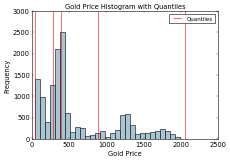

In [16]:
fig, ax = plt.subplots()
goldDF['GoldPrice'].hist(bins=30, color='#A9C5D3',
                             edgecolor='black', grid=False)
for quantile in quantiles:
    qvl = plt.axvline(quantile, color='r')
ax.legend([qvl], ['Quantiles'], fontsize=10)
ax.set_title('Gold Price Histogram with Quantiles',
             fontsize=12)
ax.set_xlabel('Gold Price', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)

In [17]:
goldDF['GoldPrice_log'] = np.log((1+ goldDF['GoldPrice']))
goldDF[[ 'GoldPrice', 'GoldPrice_log']].iloc[4:9]

GoldPrice  GoldPrice_log
Date                                
2022-03-25    1956.65       7.579500
2022-03-24    1945.90       7.573994
2022-03-23    1932.15       7.566906
2022-03-22    1929.35       7.565457
2022-03-21    1925.05       7.563227

Text(11.5, 450, '$\\mu$=5.96')

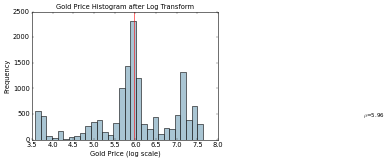

In [18]:
goldprice_log_mean = np.round(np.mean(goldDF['GoldPrice_log']), 2)
fig, ax = plt.subplots()
goldDF['GoldPrice_log'].hist(bins=30, color='#A9C5D3',
                                 edgecolor='black', grid=False)
plt.axvline(goldprice_log_mean, color='r')
ax.set_title('Gold Price Histogram after Log Transform',
             fontsize=12)
ax.set_xlabel('Gold Price (log scale)', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.text(11.5, 450, r'$\mu$='+str(goldprice_log_mean), fontsize=10)

In [19]:
goldprice = np.array(goldDF['GoldPrice'])
goldprice_clean = goldprice[~np.isnan(goldprice)]
l, opt_lambda = spstats.boxcox(goldprice_clean)
print('Optimal lambda value:', opt_lambda)

Optimal lambda value: 0.22789603593365623


In [20]:
goldDF['goldprice_boxcox_lambda_0'] = spstats.boxcox(
                                        (1+goldDF['GoldPrice']),
                                          lmbda=0)
goldDF['goldprice_boxcox_lambda_opt'] = spstats.boxcox(
                                            goldDF['GoldPrice'],
                                              lmbda=opt_lambda)

goldDF[['GoldPrice', 'GoldPrice_log',
               'goldprice_boxcox_lambda_0',
               'goldprice_boxcox_lambda_opt']].iloc[4:9]

GoldPrice  GoldPrice_log  goldprice_boxcox_lambda_0  \
Date                                                              
2022-03-25    1956.65       7.579500                   7.579500   
2022-03-24    1945.90       7.573994                   7.573994   
2022-03-23    1932.15       7.566906                   7.566906   
2022-03-22    1929.35       7.565457                   7.565457   
2022-03-21    1925.05       7.563227                   7.563227   

            goldprice_boxcox_lambda_opt  
Date                                     
2022-03-25                    20.294357  
2022-03-24                    20.263387  
2022-03-23                    20.223581  
2022-03-22                    20.215448  
2022-03-21                    20.202941

Text(24, 450, '$\\mu$=13.11')

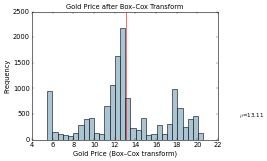

In [21]:
goldprice_boxcox_mean = np.round(
                      np.mean(
                       goldDF['goldprice_boxcox_lambda_opt']),2)
fig, ax = plt.subplots()
goldDF['goldprice_boxcox_lambda_opt'].hist(bins=30,
                     color='#A9C5D3', edgecolor='black', grid=False)
plt.axvline(goldprice_boxcox_mean, color='r')
ax.set_title('Gold Price after Box–Cox Transform',
             fontsize=12)
ax.set_xlabel('Gold Price (Box–Cox transform)', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.text(24, 450, r'$\mu$='+str(goldprice_boxcox_mean), fontsize=10)

In [22]:
#Silver price data
silverDF = pd.read_csv("/content/lbma_silver_am_usd_1967-12-31_2022-03-31.csv",parse_dates=['Date'], dayfirst=True)
silverDF = silverDF.set_index('Date')
silverDF.head()

<ipython-input-22-cd98a8833fd6>:2: UserWarning: Parsing dates in %m/%d/%Y format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  silverDF = pd.read_csv("/content/lbma_silver_am_usd_1967-12-31_2022-03-31.csv",parse_dates=['Date'], dayfirst=True)


SilverPrice
Date                   
2022-03-31       24.815
2022-03-30       24.755
2022-03-29       24.640
2022-03-28       24.905
2022-03-25       25.620

In [23]:
silverDF.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 13723 entries, 2022-03-31 to 1968-01-02
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   SilverPrice  13704 non-null  float64
dtypes: float64(1)
memory usage: 214.4 KB


In [24]:
silverDF.isnull().sum() ## missing values

SilverPrice    19
dtype: int64

In [25]:
mean_imputation_silverDF = silverDF.copy()
mean_imputation_silverDF['SilverPrice_Mean_Filled'] = mean_imputation_silverDF['SilverPrice'].fillna(silverDF['SilverPrice'].mean())

In [26]:
silverDF.SilverPrice.describe().T

count    13704.000000
mean         9.852661
std          7.993719
min          1.272000
25%          4.615000
50%          5.985500
75%         14.820000
max         49.450000
Name: SilverPrice, dtype: float64

In [27]:
mean_imputation_silverDF.SilverPrice.describe().T

count    13704.000000
mean         9.852661
std          7.993719
min          1.272000
25%          4.615000
50%          5.985500
75%         14.820000
max         49.450000
Name: SilverPrice, dtype: float64

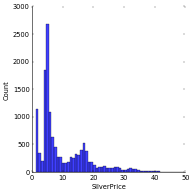

In [28]:
sns.displot(silverDF, x="SilverPrice")

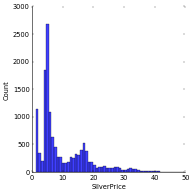

In [29]:
sns.displot(mean_imputation_silverDF, x="SilverPrice")

In [30]:
silverDF['SilverPrice_log'] = np.log((1+ silverDF['SilverPrice']))
silverDF[[ 'SilverPrice', 'SilverPrice_log']].iloc[4:9]

SilverPrice  SilverPrice_log
Date                                    
2022-03-25       25.620         3.281663
2022-03-24       25.315         3.270139
2022-03-23       25.015         3.258673
2022-03-22       25.085         3.261360
2022-03-21       25.035         3.259442

Text(11.5, 450, '$\\mu$=2.15')

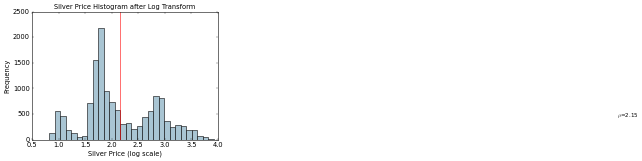

In [31]:

silverprice_log_mean = np.round(np.mean(silverDF['SilverPrice_log']), 2)
fig, ax = plt.subplots()
silverDF['SilverPrice_log'].hist(bins=30, color='#A9C5D3',
                                 edgecolor='black', grid=False)
plt.axvline(silverprice_log_mean, color='r')
ax.set_title('Silver Price Histogram after Log Transform',
             fontsize=12)
ax.set_xlabel('Silver Price (log scale)', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.text(11.5, 450, r'$\mu$='+str(silverprice_log_mean), fontsize=10)

In [32]:
! pip install impyute

In [33]:
# silverDF

In [34]:
# USD Index
# Trade Weighted U.S. Dollar Index: Broad, Goods and Services (DTWEXBGS)
# https://fred.stlouisfed.org/series/DTWEXBGS
usdFedFundsDF = pd.read_csv("/content/FEDFUNDS_2022-03-31.csv",parse_dates=['Date'], dayfirst=True)


usdFedFundsDF = usdFedFundsDF.set_index('Date')

usdFedFundsDF.head()

FEDFUNDS
Date                
1954-01-07      0.80
1954-01-08      1.22
1954-01-09      1.07
1954-01-10      0.85
1954-01-11      0.83

In [35]:
usdFedFundsDF.tail(10)

FEDFUNDS
Date                
2021-01-06      0.08
2021-01-07      0.10
2021-01-08      0.09
2021-01-09      0.08
2021-01-10      0.08
2021-01-11      0.08
2021-01-12      0.08
2022-01-01      0.08
2022-01-02      0.08
2022-01-03      0.20

In [36]:
usdFedFundsDF.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 813 entries, 1954-01-07 to 2022-01-03
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   FEDFUNDS  813 non-null    float64
dtypes: float64(1)
memory usage: 12.7 KB


In [37]:
usdFedFundsDF.isnull().sum() ## missing values

FEDFUNDS    0
dtype: int64

In [38]:
# Interest
# 10-Year Treasury Constant Maturity Rate (DGS10)
# https://fred.stlouisfed.org/series/DGS10

### https://fred.stlouisfed.org/series/FEDFUNDS
interestRateDF = pd.read_csv("/content/DGS10.csv",parse_dates=['DATE'], dayfirst=True)
interestRateDF = interestRateDF.rename(columns={"DATE":'Date'})

interestRateDF = interestRateDF.set_index('Date')

interestRateDF.head()

DGS10
Date            
1962-01-02  4.06
1962-01-03  4.03
1962-01-04  3.99
1962-01-05  4.02
1962-01-08  4.03

In [39]:
interestRateDF.tail(10)

DGS10
Date            
2022-04-06  2.61
2022-04-07  2.66
2022-04-08  2.72
2022-04-11  2.79
2022-04-12  2.72
2022-04-13  2.70
2022-04-14  2.83
2022-04-15     .
2022-04-18  2.85
2022-04-19  2.93

In [40]:
interestRateDF['DGS10'] = interestRateDF['DGS10'].replace('.',np.nan)

In [41]:
interestRateDF.isnull().sum() ## missing values

DGS10    671
dtype: int64

In [42]:
interestRateDF.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15731 entries, 1962-01-02 to 2022-04-19
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   DGS10   15060 non-null  object
dtypes: object(1)
memory usage: 245.8+ KB


In [43]:
interestRateDF.isnull().sum() ## missing values

DGS10    671
dtype: int64

In [44]:
# S&P Index
# https://finance.yahoo.com/quote/%5EGSPC/history?period1=-1325635200&period2=1611360000&interval=1d&filter=history&frequency=1d&includeAdjustedClose=true
# https://finance.yahoo.com/quote/%5EGSPC/history?period1=-628819200&period2=1650412800&interval=1d&filter=history&frequency=1d&includeAdjustedClose=true
spindex500Index = pd.read_csv("/content/SPIndex_2022-03-31.csv",parse_dates=['Date'], dayfirst=True)

spindex500Index = spindex500Index.set_index('Date')

spindex500Index.info()

<ipython-input-44-235448c39349>:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  spindex500Index = pd.read_csv("/content/SPIndex_2022-03-31.csv",parse_dates=['Date'], dayfirst=True)


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 14100 entries, 2022-04-19 to 2066-04-14
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Open         14100 non-null  object
 1   High         14100 non-null  object
 2   Low          14100 non-null  object
 3   Close*       14100 non-null  object
 4   Adj Close**  14100 non-null  object
 5   Volume       14100 non-null  object
dtypes: object(6)
memory usage: 771.1+ KB


In [45]:
spindex500Index.isnull().sum() ## missing values

Open           0
High           0
Low            0
Close*         0
Adj Close**    0
Volume         0
dtype: int64

In [46]:
spindex500Index.columns

Index(['Open', 'High', 'Low', 'Close*', 'Adj Close**', 'Volume'], dtype='object')

In [50]:
# Correcting the axis argument to use keyword syntax
spindex500Index = spindex500Index.drop('Open', axis=1)
spindex500Index = spindex500Index.drop('High', axis=1)
spindex500Index = spindex500Index.drop('Low', axis=1)
spindex500Index = spindex500Index.drop('Close*', axis=1)
spindex500Index = spindex500Index.drop('Volume', axis=1)

In [51]:
spindex500Index= spindex500Index.rename(columns={'Adj Close**':'AdjClose'})

In [52]:
spindex500Index['AdjClose'] = spindex500Index['AdjClose'].replace(',', '')

In [53]:
spindex500Index.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 14100 entries, 2022-04-19 to 2066-04-14
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   AdjClose  14100 non-null  object
dtypes: object(1)
memory usage: 220.3+ KB


In [54]:
#spindex500Index

In [58]:
spindex500Index.index = pd.to_datetime(spindex500Index.index, errors='coerce')

In [59]:
spindex500Index = spindex500Index.sort_index()

In [60]:
spindex500Index = spindex500Index.loc['1972-01-01':'2022-04-19']

In [61]:
# Crude Oil Prices: West Texas Intermediate (WTI) - Cushing, Oklahoma
# https://fred.stlouisfed.org/series/DCOILWTICO
oilPricesDF = pd.read_csv("/content/DCOILWTICO_2022-03-31.csv",parse_dates=['Date'], dayfirst=True)
oilPricesDF = oilPricesDF.set_index('Date')
oilPricesDF.head()

CrudeOilPrices(WTI)
Date                        
1/2/1986               25.56
1/3/1986                  26
1/6/1986               26.53
1/7/1986               25.85
1/8/1986               25.87

In [62]:
oilPricesDF['CrudeOilPrices(WTI)'] = oilPricesDF['CrudeOilPrices(WTI)'].replace('.',np.nan)

In [63]:
oilPricesDF.isnull().sum() ## missing values

CrudeOilPrices(WTI)    323
dtype: int64

In [64]:
oilPricesDF['CrudeOilPrices(WTI)']

Date
1/2/1986      25.56
1/3/1986         26
1/6/1986      26.53
1/7/1986      25.85
1/8/1986      25.87
              ...  
4/12/2022    100.52
4/13/2022    104.26
4/14/2022    106.84
4/15/2022       NaN
4/18/2022    108.24
Name: CrudeOilPrices(WTI), Length: 9468, dtype: object

### Exploratory analysis: ###

Let’s load the data and do some analysis with visualization to know insights of the data. Exploratory data analysis is quite extensive in multivariate time series. I will cover some areas here to get insights of the data. However, it is advisable to conduct all statistical tests to ensure our clear understanding on data distribution.

In [65]:
oilPricesDF.columns
### https://stackoverflow.com/questions/46834732/convert-pandas-datetime-column-yyyy-mm-dd-to-yyyymmdd
## https://datatofish.com/strings-to-datetime-pandas/

Index(['CrudeOilPrices(WTI)'], dtype='object')

In [66]:
pd.set_option('display.max_rows', None)
dataset = pd.concat([goldDF,silverDF,oilPricesDF,usdFedFundsDF,interestRateDF,spindex500Index], axis=1)
print('Number of colums in Dataframe : ', len(dataset.columns))
print('Number of rows in Dataframe : ', len(dataset.index))
print(dataset)

Streaming output truncated to the last 5000 lines.
2003-12-19                NaN   4.15       NaN  
2003-12-22                NaN   4.18       NaN  
2003-12-23                NaN   4.28       NaN  
2003-12-24                NaN   4.20       NaN  
2003-12-25                NaN    NaN       NaN  
2003-12-26                NaN   4.17       NaN  
2003-12-29                NaN   4.24       NaN  
2003-12-30                NaN   4.29       NaN  
2003-12-31                NaN   4.27       NaN  
2004-01-01                NaN    NaN       NaN  
2004-01-02                NaN   4.38       NaN  
2004-01-05                NaN   4.41       NaN  
2004-01-06                NaN   4.29       NaN  
2004-01-07                NaN   4.27       NaN  
2004-01-08                NaN   4.27       NaN  
2004-01-09                NaN   4.11       NaN  
2004-01-12                NaN   4.11       NaN  
2004-01-13                NaN   4.05       NaN  
2004-01-14                NaN   4.01       NaN  
2004-01-15        

In [67]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 39545 entries, 2022-03-31 00:00:00 to 2022-04-19 00:00:00
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   GoldPrice                    13712 non-null  float64
 1   GoldPrice_bin_round          13712 non-null  float64
 2   GoldPrice_log                13712 non-null  float64
 3   goldprice_boxcox_lambda_0    13712 non-null  float64
 4   goldprice_boxcox_lambda_opt  13712 non-null  float64
 5   SilverPrice                  13704 non-null  float64
 6   SilverPrice_log              13704 non-null  float64
 7   CrudeOilPrices(WTI)          9145 non-null   object 
 8   FEDFUNDS                     813 non-null    float64
 9   DGS10                        15060 non-null  object 
 10  AdjClose                     12182 non-null  object 
dtypes: float64(8), object(3)
memory usage: 3.6+ MB


In [68]:
dataset.drop(['GoldPrice_bin_round','GoldPrice_log','goldprice_boxcox_lambda_0','goldprice_boxcox_lambda_opt','SilverPrice_log'], axis = 1, inplace = True, errors = 'ignore')

***Let’s fix the dates for all the series.***

In [69]:
# dataset

In [70]:
dataset.tail()

GoldPrice  SilverPrice CrudeOilPrices(WTI)  FEDFUNDS  \
Date                                                                        
2022-04-12 00:00:00        NaN          NaN                 NaN       NaN   
2022-04-13 00:00:00        NaN          NaN                 NaN       NaN   
2022-04-14 00:00:00        NaN          NaN                 NaN       NaN   
2022-04-18 00:00:00        NaN          NaN                 NaN       NaN   
2022-04-19 00:00:00        NaN          NaN                 NaN       NaN   

                    DGS10  AdjClose  
Date                                 
2022-04-12 00:00:00   NaN  4,397.45  
2022-04-13 00:00:00   NaN  4,446.59  
2022-04-14 00:00:00   NaN  4,392.59  
2022-04-18 00:00:00   NaN  4,391.69  
2022-04-19 00:00:00   NaN  4,462.21

In [72]:
dataset.index = pd.to_datetime(dataset.index, errors='coerce')

In [73]:
print(dataset.index.min(), dataset.index.max())

1954-01-07 00:00:00 2022-04-19 00:00:00


In [82]:
# Slice with filtering to avoid missing date issues
dataset = dataset[(dataset.index >= '2010-01-01') & (dataset.index <= '2022-03-01')]

In [83]:
dataset.head()

GoldPrice  SilverPrice CrudeOilPrices(WTI)  FEDFUNDS DGS10  \
Date                                                                     
2022-03-01    1920.45       24.640                 NaN       NaN   NaN   
2022-02-28    1903.30       24.350                 NaN       NaN   NaN   
2022-02-25    1912.15       24.210                 NaN       NaN   NaN   
2022-02-24    1968.35       25.315                 NaN       NaN   NaN   
2022-02-23    1895.70       24.105                 NaN       NaN   NaN   

            AdjClose  
Date                  
2022-03-01  4,306.26  
2022-02-28  4,373.94  
2022-02-25  4,384.65  
2022-02-24  4,288.70  
2022-02-23  4,225.50

In [84]:
dataset.tail()

GoldPrice  SilverPrice CrudeOilPrices(WTI)  FEDFUNDS DGS10  \
Date                                                                     
2021-04-05        NaN          NaN                 NaN       NaN   NaN   
2021-05-03        NaN          NaN                 NaN       NaN   NaN   
2021-08-30        NaN          NaN                 NaN       NaN   NaN   
2021-12-27        NaN          NaN                 NaN       NaN   NaN   
2021-12-28        NaN          NaN                 NaN       NaN   NaN   

            AdjClose  
Date                  
2021-04-05  4,077.91  
2021-05-03  4,192.66  
2021-08-30  4,528.79  
2021-12-27  4,791.19  
2021-12-28  4,786.35

In [85]:
dataset.isnull().sum() ## missing values

GoldPrice              6456
SilverPrice            6456
CrudeOilPrices(WTI)    6474
FEDFUNDS               9383
DGS10                  6487
AdjClose               6469
dtype: int64

In [86]:
# https://stackoverflow.com/questions/31170550/pandas-df-fillnamethod-pad-not-working-on-28000-row-df
dataset=dataset.fillna(method='pad')
dataset = dataset.fillna(method = 'bfill')

<ipython-input-86-9a6c4a9c4d80>:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  dataset=dataset.fillna(method='pad')
<ipython-input-86-9a6c4a9c4d80>:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  dataset = dataset.fillna(method = 'bfill')


In [87]:
dataset.isnull().sum() ## missing values

GoldPrice              0
SilverPrice            0
CrudeOilPrices(WTI)    0
FEDFUNDS               0
DGS10                  0
AdjClose               0
dtype: int64

In [88]:
dataset=dataset.dropna()
dataset.head()

GoldPrice  SilverPrice CrudeOilPrices(WTI)  FEDFUNDS DGS10  \
Date                                                                     
2022-03-01    1920.45       24.640               81.52      0.08  3.85   
2022-02-28    1903.30       24.350               81.52      0.08  3.85   
2022-02-25    1912.15       24.210               81.52      0.08  3.85   
2022-02-24    1968.35       25.315               81.52      0.08  3.85   
2022-02-23    1895.70       24.105               81.52      0.08  3.85   

            AdjClose  
Date                  
2022-03-01  4,306.26  
2022-02-28  4,373.94  
2022-02-25  4,384.65  
2022-02-24  4,288.70  
2022-02-23  4,225.50

In [89]:
#print(dataset)

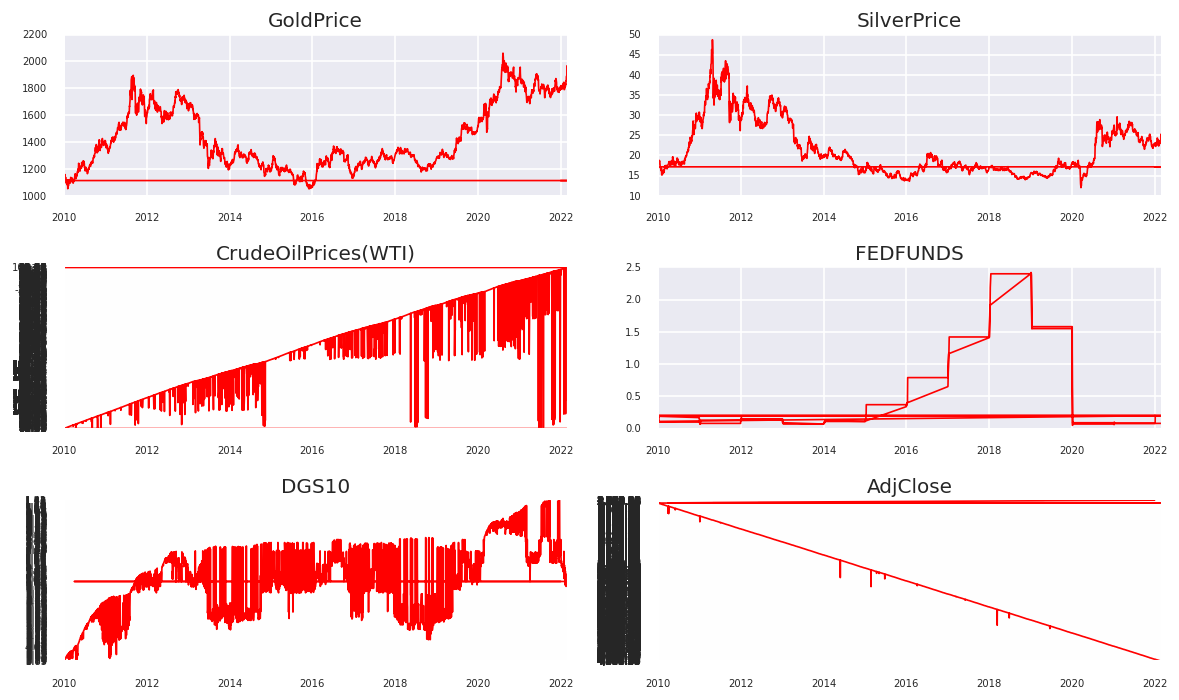

In [90]:
# Plot
fig, axes = plt.subplots(nrows=3, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
 data = dataset[dataset.columns[i]]
 ax.plot(data, color='red', linewidth=1)
 ax.set_title(dataset.columns[i])
 ax.xaxis.set_ticks_position('none')
 ax.yaxis.set_ticks_position('none')
 ax.spines["top"].set_alpha(0)
 ax.tick_params(labelsize=6)
plt.tight_layout();

***From the above plots, we can visible conclude that, all the series contain unit root with stochastic trend showing a systematic pattern that is unpredictable.***

### Normality Test ###
To extract maximum information from our data, it is important to have a ***normal or Gaussian distribution*** of the data.
To check for that, we have done a normality test based on the Null and Alternate Hypothesis intuition.


In [91]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9530 entries, 2022-03-01 to 2021-12-28
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   GoldPrice            9530 non-null   float64
 1   SilverPrice          9530 non-null   float64
 2   CrudeOilPrices(WTI)  9530 non-null   object 
 3   FEDFUNDS             9530 non-null   float64
 4   DGS10                9530 non-null   object 
 5   AdjClose             9530 non-null   object 
dtypes: float64(3), object(3)
memory usage: 521.2+ KB


In [92]:
itemcost='1,455.22'
itemcostProc=itemcost.replace(',','')
print(itemcostProc)
print(float(itemcostProc))

1455.22
1455.22


In [93]:
dataset['AdjClose']= dataset['AdjClose'].apply(lambda x: x.replace(',',''))

In [94]:
dataset['AdjClose']

Date
2022-03-01    4306.26
2022-02-28    4373.94
2022-02-25    4384.65
2022-02-24    4288.70
2022-02-23    4225.50
2022-02-22    4304.76
2022-02-21    4304.76
2022-02-18    4348.87
2022-02-17    4380.26
2022-02-16    4475.01
2022-02-15    4471.07
2022-02-14    4401.67
2022-02-11    4418.64
2022-02-10    4504.08
2022-02-09    4587.18
2022-02-08    4521.54
2022-02-07    4483.87
2022-02-04    4500.53
2022-02-03    4477.44
2022-02-02    4589.38
2022-02-01    4546.54
2022-01-31    4515.55
2022-01-28    4431.85
2022-01-27    4326.51
2022-01-26    4349.93
2022-01-25    4356.45
2022-01-24    4410.13
2022-01-21    4397.94
2022-01-20    4482.73
2022-01-19    4532.76
2022-01-18    4577.11
2022-01-17    4577.11
2022-01-14    4662.85
2022-01-13    4659.03
2022-01-12    4726.35
2022-01-11    4713.07
2022-01-10    4670.29
2022-01-07    4677.03
2022-01-06    4696.05
2022-01-05    4700.58
2022-01-04    4793.54
2021-12-31    4766.18
2021-12-30    4778.73
2021-12-29    4793.06
2021-12-24    4793.06
2021-12-23    4725.79
2021-12-22    4696.56
2021-12-21    4649.23
2021-12-20    4568.02
2021-12-17    4620.64
2021-12-16    4668.67
2021-12-15    4709.85
2021-12-14    4634.09
2021-12-13    4668.97
2021-12-10    4712.02
2021-12-09    4667.45
2021-12-08    4701.21
2021-12-07    4686.75
2021-12-06    4591.67
2021-12-03    4538.43
2021-12-02    4577.10
2021-12-01    4513.04
2021-11-30    4567.00
2021-11-29    4655.27
2021-11-26    4594.62
2021-11-25    4594.62
2021-11-24    4701.46
2021-11-23    4690.70
2021-11-22    4682.94
2021-11-19    4697.96
2021-11-18    4704.54
2021-11-17    4688.67
2021-11-16    4700.90
2021-11-15    4682.80
2021-11-12    4682.85
2021-11-11    4649.27
2021-11-10    4646.71
2021-11-09    4685.25
2021-11-08    4701.70
2021-11-05    4697.53
2021-11-04    4680.06
2021-11-03    4660.57
2021-11-02    4630.65
2021-11-01    4613.67
2021-10-29    4605.38
2021-10-28    4596.42
2021-10-27    4551.68
2021-10-26    4574.79
2021-10-25    4566.48
2021-10-22    4544.90
2021-10-21    4549.78
2021-10-20    4536.19
2021-10-19    4519.63
2021-10-18    4486.46
2021-10-15    4471.37
2021-10-14    4438.26
2021-10-13    4363.80
2021-10-12    4350.65
2021-10-11    4361.19
2021-10-08    4391.34
2021-10-07    4399.76
2021-10-06    4363.55
2021-10-05    4345.72
2021-10-04    4300.46
2021-10-01    4357.04
2021-09-30    4307.54
2021-09-29    4359.46
2021-09-28    4352.63
2021-09-27    4443.11
2021-09-24    4455.48
2021-09-23    4448.98
2021-09-22    4395.64
2021-09-21    4354.19
2021-09-20    4357.73
2021-09-17    4432.99
2021-09-16    4473.75
2021-09-15    4480.70
2021-09-14    4443.05
2021-09-13    4468.73
2021-09-10    4458.58
2021-09-09    4493.28
2021-09-08    4514.07
2021-09-07    4520.03
2021-09-06    4520.03
2021-09-03    4535.43
2021-09-02    4536.95
2021-09-01    4524.09
2021-08-31    4522.68
2021-08-27    4509.37
2021-08-26    4470.00
2021-08-25    4496.19
2021-08-24    4486.23
2021-08-23    4479.53
2021-08-20    4441.67
2021-08-19    4405.80
2021-08-18    4400.27
2021-08-17    4448.08
2021-08-16    4479.71
2021-08-13    4468.00
2021-08-12    4460.83
2021-08-11    4442.41
2021-08-10    4436.75
2021-08-09    4432.35
2021-08-06    4436.52
2021-08-05    4429.10
2021-08-04    4402.66
2021-08-03    4423.15
2021-08-02    4387.16
2021-07-30    4395.26
2021-07-29    4419.15
2021-07-28    4400.64
2021-07-27    4401.46
2021-07-26    4422.30
2021-07-23    4411.79
2021-07-22    4367.48
2021-07-21    4358.69
2021-07-20    4323.06
2021-07-19    4258.49
2021-07-16    4327.16
2021-07-15    4360.03
2021-07-14    4374.30
2021-07-13    4369.21
2021-07-12    4384.63
2021-07-09    4369.55
2021-07-08    4320.82
2021-07-07    4358.13
2021-07-06    4343.54
2021-07-05    4343.54
2021-07-02    4352.34
2021-07-01    4319.94
2021-06-30    4297.50
2021-06-29    4291.80
2021-06-28    4290.61
2021-06-25    4280.70
2021-06-24    4266.49
2021-06-23    4241.84
2021-06-22    4246.44
2021-06-21    4224.79
2021-06-18    4166.45
2021-06-17    4221.86
2021-06-16    4223.70
2021-06-15   

In [95]:
dataset['CrudeOilPrices(WTI)'] = dataset['CrudeOilPrices(WTI)'].astype('float64')
dataset['CrudeOilPrices(WTI)'] = dataset['CrudeOilPrices(WTI)'].astype('float64')
dataset['DGS10'] = dataset['DGS10'].astype('float64')
dataset['AdjClose'] = dataset['AdjClose'].astype('float64')
dataset.dtypes

GoldPrice              float64
SilverPrice            float64
CrudeOilPrices(WTI)    float64
FEDFUNDS               float64
DGS10                  float64
AdjClose               float64
dtype: object

In [96]:
dataset['CrudeOilPrices(WTI)']

Date
2022-03-01     81.52
2022-02-28     81.52
2022-02-25     81.52
2022-02-24     81.52
2022-02-23     81.52
2022-02-22     81.52
2022-02-21     81.52
2022-02-18     81.52
2022-02-17     81.52
2022-02-16     81.52
2022-02-15     81.52
2022-02-14     81.52
2022-02-11     81.52
2022-02-10     81.52
2022-02-09     81.52
2022-02-08     81.52
2022-02-07     81.52
2022-02-04     81.52
2022-02-03     81.52
2022-02-02     81.52
2022-02-01     81.52
2022-01-31     81.52
2022-01-28     81.52
2022-01-27     81.52
2022-01-26     81.52
2022-01-25     81.52
2022-01-24     81.52
2022-01-21     81.52
2022-01-20     81.52
2022-01-19     81.52
2022-01-18     81.52
2022-01-17     81.52
2022-01-14     81.52
2022-01-13     81.52
2022-01-12     81.52
2022-01-11     81.52
2022-01-10     81.52
2022-01-07     81.52
2022-01-06     81.52
2022-01-05     81.52
2022-01-04     81.52
2021-12-31     81.52
2021-12-30     81.52
2021-12-29     81.52
2021-12-24     81.52
2021-12-23     81.52
2021-12-22     81.52
2021-12-21     81.52
2021-12-20     81.52
2021-12-17     81.52
2021-12-16     81.52
2021-12-15     81.52
2021-12-14     81.52
2021-12-13     81.52
2021-12-10     81.52
2021-12-09     81.52
2021-12-08     81.52
2021-12-07     81.52
2021-12-06     81.52
2021-12-03     81.52
2021-12-02     81.52
2021-12-01     81.52
2021-11-30     81.52
2021-11-29     81.52
2021-11-26     81.52
2021-11-25     81.52
2021-11-24     81.52
2021-11-23     81.52
2021-11-22     81.52
2021-11-19     81.52
2021-11-18     81.52
2021-11-17     81.52
2021-11-16     81.52
2021-11-15     81.52
2021-11-12     81.52
2021-11-11     81.52
2021-11-10     81.52
2021-11-09     81.52
2021-11-08     81.52
2021-11-05     81.52
2021-11-04     81.52
2021-11-03     81.52
2021-11-02     81.52
2021-11-01     81.52
2021-10-29     81.52
2021-10-28     81.52
2021-10-27     81.52
2021-10-26     81.52
2021-10-25     81.52
2021-10-22     81.52
2021-10-21     81.52
2021-10-20     81.52
2021-10-19     81.52
2021-10-18     81.52
2021-10-15     81.52
2021-10-14     81.52
2021-10-13     81.52
2021-10-12     81.52
2021-10-11     81.52
2021-10-08     81.52
2021-10-07     81.52
2021-10-06     81.52
2021-10-05     81.52
2021-10-04     81.52
2021-10-01     81.52
2021-09-30     81.52
2021-09-29     81.52
2021-09-28     81.52
2021-09-27     81.52
2021-09-24     81.52
2021-09-23     81.52
2021-09-22     81.52
2021-09-21     81.52
2021-09-20     81.52
2021-09-17     81.52
2021-09-16     81.52
2021-09-15     81.52
2021-09-14     81.52
2021-09-13     81.52
2021-09-10     81.52
2021-09-09     81.52
2021-09-08     81.52
2021-09-07     81.52
2021-09-06     81.52
2021-09-03     81.52
2021-09-02     81.52
2021-09-01     81.52
2021-08-31     81.52
2021-08-27     81.52
2021-08-26     81.52
2021-08-25     81.52
2021-08-24     81.52
2021-08-23     81.52
2021-08-20     81.52
2021-08-19     81.52
2021-08-18     81.52
2021-08-17     81.52
2021-08-16     81.52
2021-08-13     81.52
2021-08-12     81.52
2021-08-11     81.52
2021-08-10     81.52
2021-08-09     81.52
2021-08-06     81.52
2021-08-05     81.52
2021-08-04     81.52
2021-08-03     81.52
2021-08-02     81.52
2021-07-30     81.52
2021-07-29     81.52
2021-07-28     81.52
2021-07-27     81.52
2021-07-26     81.52
2021-07-23     81.52
2021-07-22     81.52
2021-07-21     81.52
2021-07-20     81.52
2021-07-19     81.52
2021-07-16     81.52
2021-07-15     81.52
2021-07-14     81.52
2021-07-13     81.52
2021-07-12     81.52
2021-07-09     81.52
2021-07-08     81.52
2021-07-07     81.52
2021-07-06     81.52
2021-07-05     81.52
2021-07-02     81.52
2021-07-01     81.52
2021-06-30     81.52
2021-06-29     81.52
2021-06-28     81.52
2021-06-25     81.52
2021-06-24     81.52
2021-06-23     81.52
2021-06-22     81.52
2021-06-21     81.52
2021-06-18     81.52
2021-06-17     81.52
2021-06-16     81.52
2021-06-15     81.52
2021-06-14     81.52
2021-06-11     81.52
2021-06-10     81.52
2021-06-09     81.52
2021-06-08     81.52
2021-06-07     81.52
2021-06-04     81.52
2021-06-03     81.52
2021-

In [97]:
from scipy import stats

GoldPrice=dataset.GoldPrice.values
print(GoldPrice)


stat,p = stats.normaltest(GoldPrice)

print("GoldPrice Statistics = %.3f, p=%.3f" % (stat,p))
alpha = 0.05
if p> alpha:
    print('Data looks Gaussian (fail to reject null hypothesis)')
else:
    print('Data looks non-Gaussian (reject null hypothesis)')


[1920.45 1903.3  1912.15 ... 1113.   1113.   1113.  ]
GoldPrice Statistics = 3737.390, p=0.000
Data looks non-Gaussian (reject null hypothesis)


In [98]:
from scipy import stats

SilverPrice=dataset.SilverPrice.values
print(SilverPrice)


stat,p = stats.normaltest(SilverPrice)

print("SilverPrice Statistics = %.3f, p=%.3f" % (stat,p))
alpha = 0.05
if p> alpha:
    print('Data looks Gaussian (fail to reject null hypothesis)')
else:
    print('Data looks non-Gaussian (reject null hypothesis)')


[24.64 24.35 24.21 ... 17.17 17.17 17.17]
SilverPrice Statistics = 5958.365, p=0.000
Data looks non-Gaussian (reject null hypothesis)


In [99]:
from scipy import stats

OilPrice=dataset['CrudeOilPrices(WTI)'].values
print(OilPrice)


stat,p = stats.normaltest(OilPrice)

print("OilPrice Statistics = %.3f, p=%.3f" % (stat,p))
alpha = 0.05
if p> alpha:
    print('Data looks Gaussian (fail to reject null hypothesis)')
else:
    print('Data looks non-Gaussian (reject null hypothesis)')

[ 81.52  81.52  81.52 ... 103.66 103.66 103.66]
OilPrice Statistics = 1092.738, p=0.000
Data looks non-Gaussian (reject null hypothesis)


In [100]:
from scipy import stats

FEDFUNDS=dataset.FEDFUNDS.values
print(FEDFUNDS)


stat,p = stats.normaltest(FEDFUNDS)

print("FEDFUNDS Statistics = %.3f, p=%.3f" % (stat,p))
alpha = 0.05
if p> alpha:
    print('Data looks Gaussian (fail to reject null hypothesis)')
else:
    print('Data looks non-Gaussian (reject null hypothesis)')

[0.08 0.08 0.08 ... 0.2  0.2  0.2 ]
FEDFUNDS Statistics = 6256.216, p=0.000
Data looks non-Gaussian (reject null hypothesis)


In [101]:
from scipy import stats

InterestRate=dataset.DGS10.values
print(InterestRate)


stat,p = stats.normaltest(InterestRate)

print("InterestRate Statistics = %.3f, p=%.3f" % (stat,p))
alpha = 0.05
if p> alpha:
    print('Data looks Gaussian (fail to reject null hypothesis)')
else:
    print('Data looks non-Gaussian (reject null hypothesis)')

[3.85 3.85 3.85 ... 1.72 1.72 1.72]
InterestRate Statistics = 1602.501, p=0.000
Data looks non-Gaussian (reject null hypothesis)


In [102]:
dataset.describe()

GoldPrice  SilverPrice  CrudeOilPrices(WTI)     FEDFUNDS  \
count  9530.000000  9530.000000          9530.000000  9530.000000   
mean   1213.947508    18.538998            85.157875     0.329605   
std     199.486183     4.243666            19.230540     0.464478   
min    1050.600000    12.005000           -36.980000     0.050000   
25%    1113.000000    17.170000            81.520000     0.200000   
50%    1113.000000    17.170000            81.520000     0.200000   
75%    1231.500000    17.170000           103.660000     0.200000   
max    2061.500000    48.700000           113.390000     2.420000   

             DGS10     AdjClose  
count  9530.000000  9530.000000  
mean      3.286693  2733.432357  
std       0.885529  1620.727150  
min       0.520000  1022.580000  
25%       2.640000  1132.990000  
50%       3.850000  2085.315000  
75%       3.850000  4796.560000  
max       4.010000  4796.560000

In [103]:
weekly_data = dataset.resample('W').mean()

In [104]:
#weekly_data

In [105]:
monthly_data = dataset.resample('M').mean()

<ipython-input-105-eabd3085f651>:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_data = dataset.resample('M').mean()


In [106]:
#monthly_data

In [107]:
# Plot
# Takes long time
# fig, axes = plt.subplots(nrows=3, ncols=2, dpi=120, figsize=(10,6))
# for i, ax in enumerate(axes.flatten()):
#  data = monthly_data[monthly_data.columns[i]]
#  ax.plot(data, color='red', linewidth=1)
#  ax.set_title(monthly_data.columns[i])
#  ax.xaxis.set_ticks_position('none')
#  ax.yaxis.set_ticks_position('none')
#  ax.spines["top"].set_alpha(0)
#  ax.tick_params(labelsize=6)
# plt.tight_layout();

In [108]:
yearly_data = dataset.resample('Y').mean()

<ipython-input-108-3eb9365cf937>:1: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  yearly_data = dataset.resample('Y').mean()


In [109]:
yearly_data

GoldPrice  SilverPrice  CrudeOilPrices(WTI)  FEDFUNDS     DGS10  \
Date                                                                            
2010-12-31  1149.633312    18.144255            88.480318  0.168280  3.624713   
2011-12-31  1260.887516    22.938566            93.630858  0.176620  3.479309   
2012-12-31  1291.668367    21.663469            93.355408  0.183520  3.151747   
2013-12-31  1208.805875    19.309930            94.605351  0.157905  3.339413   
2014-12-31  1162.393941    17.785670            93.017806  0.170064  3.403087   
2015-12-31  1128.109375    16.689171            78.212564  0.252309  3.269668   
2016-12-31  1157.160140    17.159541            76.400893  0.388112  3.170969   
2017-12-31  1159.800833    17.130603            78.899718  0.593974  3.332423   
2018-12-31  1163.447570    16.696151            83.574425  0.911483  3.524987   
2019-12-31  1203.703193    16.859336            80.943078  0.661814  3.269974   
2020-12-31  1325.379543    18.259263            75.113189  0.161881  2.855972   
2021-12-31  1334.149490    19.737255            84.689669  0.160561  3.036701   
2022-12-31  1345.562500    19.142969            91.338906  0.159688  3.191797   

               AdjClose  
Date                     
2010-12-31  2353.328650  
2011-12-31  2397.195839  
2012-12-31  2434.353138  
2013-12-31  2522.398902  
2014-12-31  2615.319809  
2015-12-31  2657.668546  
2016-12-31  2668.481263  
2017-12-31  2786.685551  
2018-12-31  2886.422558  
2019-12-31  2939.101098  
2020-12-31  3037.941512  
2021-12-31  3384.519529  
2022-12-31  3441.663359

In [110]:
# Plot
# Takes long time
# fig, axes = plt.subplots(nrows=3, ncols=2, dpi=120, figsize=(10,6))
# for i, ax in enumerate(axes.flatten()):
#  data = yearly_data[yearly_data.columns[i]]
#  ax.plot(data, color='red', linewidth=1)
#  ax.set_title(yearly_data.columns[i])
#  ax.xaxis.set_ticks_position('none')
#  ax.yaxis.set_ticks_position('none')
#  ax.spines["top"].set_alpha(0)
#  ax.tick_params(labelsize=6)
# plt.tight_layout();

Gold: Kurtosis of normal distribution: 3.3705542817678413
Gold:Skewness of normal distribution: 2.106253630463052


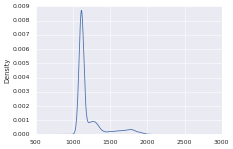

In [111]:
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import kurtosis

dataset.GoldPrice.plot(kind = 'density')

print('Gold: Kurtosis of normal distribution: {}'.format(stats.kurtosis(dataset.GoldPrice)))
print('Gold:Skewness of normal distribution: {}'.format(stats.skew(dataset.GoldPrice)))

These two distributions give us some intuition about the distribution of our data. The kurtosis of this dataset is -0.18. Since this value is less than 0, it is considered to be a light-tailed dataset. It has as much data in each tail as it does in the peak. Moderate skewness refers to the value between -1 and -0.5 or 0.5 and 1.

Silver: Kurtosis of normal distribution: 9.508574401660388
Silver:Skewness of normal distribution: 3.02877389544658


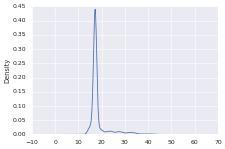

In [112]:
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import kurtosis

dataset.SilverPrice.plot(kind = 'density')

print('Silver: Kurtosis of normal distribution: {}'.format(stats.kurtosis(dataset.SilverPrice)))
print('Silver:Skewness of normal distribution: {}'.format(stats.skew(dataset.SilverPrice)))

These two distributions give us some intuition about the distribution of our data. The kurtosis of this dataset is -0.95. Since this value is less than 0, it is considered to be a light-tailed dataset. It has as much data in each tail as it does in the peak. Moderate skewness refers to the value between -1 and -0.5 or 0.5 and 1.

Oil: Kurtosis of normal distribution: 0.3873690565255279
Oil:Skewness of normal distribution: -0.9528780024569348


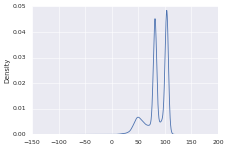

In [113]:
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import kurtosis

dataset['CrudeOilPrices(WTI)'].plot(kind = 'density')

print('Oil: Kurtosis of normal distribution: {}'.format(stats.kurtosis(dataset['CrudeOilPrices(WTI)'])))
print('Oil:Skewness of normal distribution: {}'.format(stats.skew(dataset['CrudeOilPrices(WTI)'])))

These two distributions give us some intuition about the distribution of our data. The kurtosis of this dataset is -1.16. Since this value is less than 0, it is considered to be a light-tailed dataset. It has as much data in each tail as it does in the peak. Moderate skewness refers to the value between -1 and -0.5 or 0.5 and 1.

FEDFUNDS: Kurtosis of normal distribution: 9.820617467509035
FEDFUNDS:Skewness of normal distribution: 3.227064084601077


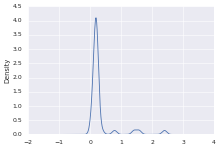

In [114]:
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import kurtosis

dataset.FEDFUNDS.plot(kind = 'density')

print('FEDFUNDS: Kurtosis of normal distribution: {}'.format(stats.kurtosis(dataset.FEDFUNDS)))
print('FEDFUNDS:Skewness of normal distribution: {}'.format(stats.skew(dataset.FEDFUNDS)))

These two distributions give us some intuition about the distribution of our data. The kurtosis of this dataset is -1.43. Since this value is less than 0, it is considered to be a light-tailed dataset. It has as much data in each tail as it does in the peak. Moderate skewness refers to the value between -1 and -0.5 or 0.5 and 1.

count    9530.000000
mean     1213.947508
std       199.486183
min      1050.600000
25%      1113.000000
50%      1113.000000
75%      1231.500000
max      2061.500000
Name: GoldPrice, dtype: float64

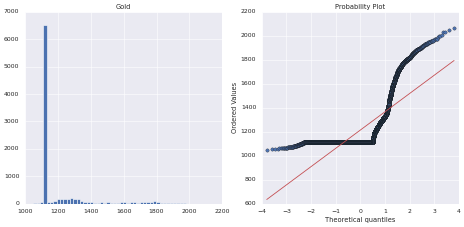

In [115]:
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
dataset['GoldPrice'].hist(bins=50)
plt.title('Gold')
plt.subplot(1,2,2)
stats.probplot(dataset['GoldPrice'], plot=plt);
dataset.GoldPrice.describe().T

Normal probability plot also shows the data is far from normally distributed.

count    9530.000000
mean       18.538998
std         4.243666
min        12.005000
25%        17.170000
50%        17.170000
75%        17.170000
max        48.700000
Name: SilverPrice, dtype: float64

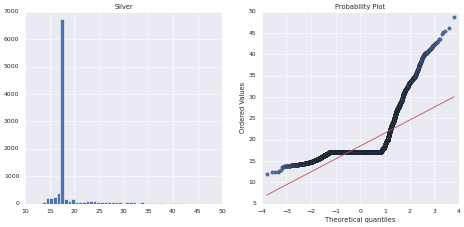

In [116]:
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
dataset['SilverPrice'].hist(bins=50)
plt.title('Silver')
plt.subplot(1,2,2)
stats.probplot(dataset['SilverPrice'], plot=plt);
dataset.SilverPrice.describe().T

Normal probability plot also shows the data is far from normally distributed.

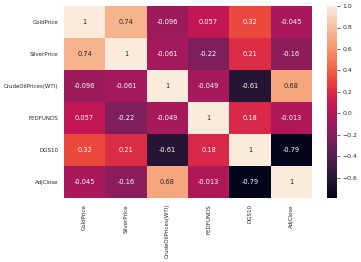

In [117]:

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns; sns.set()
corr = dataset.corr()

fig, ax = plt.subplots()
sns.heatmap(corr,xticklabels=corr.columns.values, yticklabels=corr.columns.values, annot=True,annot_kws={'size':12})
heat_map=plt.gcf()
heat_map.set_size_inches(10,6)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

In [118]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9530 entries, 2022-03-01 to 2021-12-28
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   GoldPrice            9530 non-null   float64
 1   SilverPrice          9530 non-null   float64
 2   CrudeOilPrices(WTI)  9530 non-null   float64
 3   FEDFUNDS             9530 non-null   float64
 4   DGS10                9530 non-null   float64
 5   AdjClose             9530 non-null   float64
dtypes: float64(6)
memory usage: 521.2 KB


In [119]:
#dataset

### Auto-correlation ###

###### Auto-correlation or serial correlation can be a significant problem in analyzing historical data if we do not know how to look out for it. #######

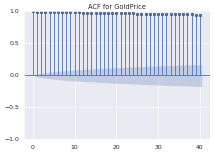

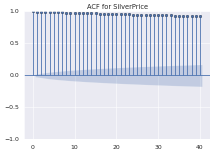

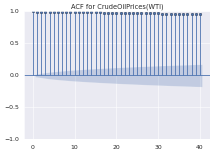

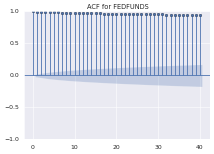

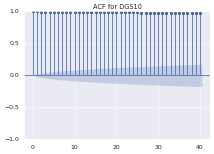

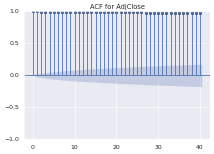

In [120]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

# plots the autocorrelation plots for each stock's price at 50 lags
for i in dataset:
    series = dataset[i]
    sm.graphics.tsa.plot_acf(series)
    plt.title('ACF for %s' % i)
    plt.show()

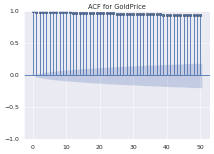

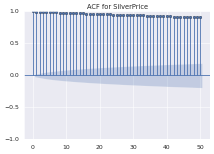

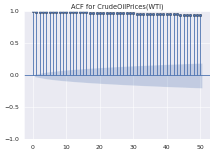

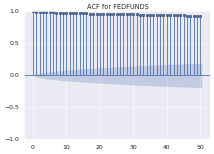

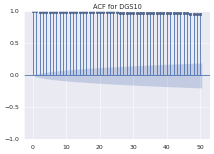

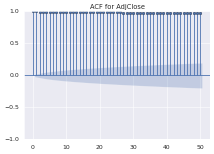

In [121]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

# plots the autocorrelation plots for each stock's price at 50 lags
for i in dataset:
    sm.graphics.tsa.plot_acf(dataset[i], lags = 50)
    plt.title('ACF for %s' % i)
plt.show()

We see here from the above plots, the auto-correlation of +1 which represents a perfect positive correlation which means, an increase seen in one time series leads to a proportionate increase in the other time series. We definitely need to apply transformation and neutralize this to make the series stationary. It measures linear relationships; even if the auto-correlation is minuscule, there may still be a nonlinear relationship between a time series and a lagged version of itself.

In [122]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9530 entries, 2022-03-01 to 2021-12-28
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   GoldPrice            9530 non-null   float64
 1   SilverPrice          9530 non-null   float64
 2   CrudeOilPrices(WTI)  9530 non-null   float64
 3   FEDFUNDS             9530 non-null   float64
 4   DGS10                9530 non-null   float64
 5   AdjClose             9530 non-null   float64
dtypes: float64(6)
memory usage: 521.2 KB


In [123]:
dataset['AdjClose']

Date
2022-03-01    4306.26
2022-02-28    4373.94
2022-02-25    4384.65
2022-02-24    4288.70
2022-02-23    4225.50
2022-02-22    4304.76
2022-02-21    4304.76
2022-02-18    4348.87
2022-02-17    4380.26
2022-02-16    4475.01
2022-02-15    4471.07
2022-02-14    4401.67
2022-02-11    4418.64
2022-02-10    4504.08
2022-02-09    4587.18
2022-02-08    4521.54
2022-02-07    4483.87
2022-02-04    4500.53
2022-02-03    4477.44
2022-02-02    4589.38
2022-02-01    4546.54
2022-01-31    4515.55
2022-01-28    4431.85
2022-01-27    4326.51
2022-01-26    4349.93
2022-01-25    4356.45
2022-01-24    4410.13
2022-01-21    4397.94
2022-01-20    4482.73
2022-01-19    4532.76
2022-01-18    4577.11
2022-01-17    4577.11
2022-01-14    4662.85
2022-01-13    4659.03
2022-01-12    4726.35
2022-01-11    4713.07
2022-01-10    4670.29
2022-01-07    4677.03
2022-01-06    4696.05
2022-01-05    4700.58
2022-01-04    4793.54
2021-12-31    4766.18
2021-12-30    4778.73
2021-12-29    4793.06
2021-12-24    4793.06
2021-12-23    4725.79
2021-12-22    4696.56
2021-12-21    4649.23
2021-12-20    4568.02
2021-12-17    4620.64
2021-12-16    4668.67
2021-12-15    4709.85
2021-12-14    4634.09
2021-12-13    4668.97
2021-12-10    4712.02
2021-12-09    4667.45
2021-12-08    4701.21
2021-12-07    4686.75
2021-12-06    4591.67
2021-12-03    4538.43
2021-12-02    4577.10
2021-12-01    4513.04
2021-11-30    4567.00
2021-11-29    4655.27
2021-11-26    4594.62
2021-11-25    4594.62
2021-11-24    4701.46
2021-11-23    4690.70
2021-11-22    4682.94
2021-11-19    4697.96
2021-11-18    4704.54
2021-11-17    4688.67
2021-11-16    4700.90
2021-11-15    4682.80
2021-11-12    4682.85
2021-11-11    4649.27
2021-11-10    4646.71
2021-11-09    4685.25
2021-11-08    4701.70
2021-11-05    4697.53
2021-11-04    4680.06
2021-11-03    4660.57
2021-11-02    4630.65
2021-11-01    4613.67
2021-10-29    4605.38
2021-10-28    4596.42
2021-10-27    4551.68
2021-10-26    4574.79
2021-10-25    4566.48
2021-10-22    4544.90
2021-10-21    4549.78
2021-10-20    4536.19
2021-10-19    4519.63
2021-10-18    4486.46
2021-10-15    4471.37
2021-10-14    4438.26
2021-10-13    4363.80
2021-10-12    4350.65
2021-10-11    4361.19
2021-10-08    4391.34
2021-10-07    4399.76
2021-10-06    4363.55
2021-10-05    4345.72
2021-10-04    4300.46
2021-10-01    4357.04
2021-09-30    4307.54
2021-09-29    4359.46
2021-09-28    4352.63
2021-09-27    4443.11
2021-09-24    4455.48
2021-09-23    4448.98
2021-09-22    4395.64
2021-09-21    4354.19
2021-09-20    4357.73
2021-09-17    4432.99
2021-09-16    4473.75
2021-09-15    4480.70
2021-09-14    4443.05
2021-09-13    4468.73
2021-09-10    4458.58
2021-09-09    4493.28
2021-09-08    4514.07
2021-09-07    4520.03
2021-09-06    4520.03
2021-09-03    4535.43
2021-09-02    4536.95
2021-09-01    4524.09
2021-08-31    4522.68
2021-08-27    4509.37
2021-08-26    4470.00
2021-08-25    4496.19
2021-08-24    4486.23
2021-08-23    4479.53
2021-08-20    4441.67
2021-08-19    4405.80
2021-08-18    4400.27
2021-08-17    4448.08
2021-08-16    4479.71
2021-08-13    4468.00
2021-08-12    4460.83
2021-08-11    4442.41
2021-08-10    4436.75
2021-08-09    4432.35
2021-08-06    4436.52
2021-08-05    4429.10
2021-08-04    4402.66
2021-08-03    4423.15
2021-08-02    4387.16
2021-07-30    4395.26
2021-07-29    4419.15
2021-07-28    4400.64
2021-07-27    4401.46
2021-07-26    4422.30
2021-07-23    4411.79
2021-07-22    4367.48
2021-07-21    4358.69
2021-07-20    4323.06
2021-07-19    4258.49
2021-07-16    4327.16
2021-07-15    4360.03
2021-07-14    4374.30
2021-07-13    4369.21
2021-07-12    4384.63
2021-07-09    4369.55
2021-07-08    4320.82
2021-07-07    4358.13
2021-07-06    4343.54
2021-07-05    4343.54
2021-07-02    4352.34
2021-07-01    4319.94
2021-06-30    4297.50
2021-06-29    4291.80
2021-06-28    4290.61
2021-06-25    4280.70
2021-06-24    4266.49
2021-06-23    4241.84
2021-06-22    4246.44
2021-06-21    4224.79
2021-06-18    4166.45
2021-06-17    4221.86
2021-06-16    4223.70
2021-06-15   

### Train and Test Data: ###
The VAR model will be fitted on X_train and then used to forecast the next 15 observations. These forecasts will be compared against the actual present in test data.

In [124]:
n_obs=15
X_train, X_test = dataset[0:-n_obs], dataset[-n_obs:]
print(X_train.shape, X_test.shape)

(9515, 6) (15, 6)


### Transformation: ###

Applying first differencing on training set to make all the series stationary. However, this is an iterative process where we after first differencing, the series may still be non-stationary. We shall have to apply second difference or log transformation to standardize the series in such cases.

In [125]:
transform_data = X_train.diff().dropna()
transform_data.head()


GoldPrice  SilverPrice  CrudeOilPrices(WTI)  FEDFUNDS  DGS10  \
Date                                                                       
2022-02-28     -17.15       -0.290                  0.0       0.0    0.0   
2022-02-25       8.85       -0.140                  0.0       0.0    0.0   
2022-02-24      56.20        1.105                  0.0       0.0    0.0   
2022-02-23     -72.65       -1.210                  0.0       0.0    0.0   
2022-02-22      -0.70       -0.095                  0.0       0.0    0.0   

            AdjClose  
Date                  
2022-02-28     67.68  
2022-02-25     10.71  
2022-02-24    -95.95  
2022-02-23    -63.20  
2022-02-22     79.26

In [126]:
transform_data.describe()

GoldPrice  SilverPrice  CrudeOilPrices(WTI)     FEDFUNDS  \
count  9514.000000  9514.000000          9514.000000  9514.000000   
mean     -0.084870    -0.000785             0.002327     0.000013   
std       8.299403     0.301253             1.087202     0.024204   
min    -105.000000    -5.340000           -55.290000    -1.500000   
25%       0.000000     0.000000             0.000000     0.000000   
50%       0.000000     0.000000             0.000000     0.000000   
75%       0.000000     0.000000             0.000000     0.000000   
max     133.500000     6.680000            45.890000     0.930000   

             DGS10     AdjClose  
count  9514.000000  9514.000000  
mean     -0.000224    -0.171708  
std       0.027705    54.213529  
min      -0.210000 -3609.120000  
25%       0.000000     0.000000  
50%       0.000000     0.000000  
75%       0.000000     0.000000  
max       0.290000  3524.690000

### Stationarity check ###


In [127]:
!pip install statsmodels

In [128]:
import statsmodels.tsa.stattools as sm
def augmented_dickey_fuller_statistics(time_series):
    result = sm.adfuller(time_series.values, autolag='AIC')
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

In [129]:
print('Augmented Dickey-Fuller Test: Gold Price Time Series')
augmented_dickey_fuller_statistics(transform_data['GoldPrice'])
print('Augmented Dickey-Fuller Test: Silver Price Time Series')
augmented_dickey_fuller_statistics(transform_data['SilverPrice'])
print('Augmented Dickey-Fuller Test: CrudeOilPrices(WTI)  Time Series')
augmented_dickey_fuller_statistics(transform_data['CrudeOilPrices(WTI)'])
print('Augmented Dickey-Fuller Test: FEDFUNDS Time Series')
augmented_dickey_fuller_statistics(transform_data['FEDFUNDS'])
print('Augmented Dickey-Fuller Test: DGS10 Time Series')
augmented_dickey_fuller_statistics(transform_data['DGS10'])
print('Augmented Dickey-Fuller Test: AdjClose Time Series')
augmented_dickey_fuller_statistics(transform_data['AdjClose'])

##GoldPrice	SilverPrice	CrudeOilPrices(WTI)	FEDFUNDS	DGS10	AdjClose


Augmented Dickey-Fuller Test: Gold Price Time Series
ADF Statistic: -16.593993
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Augmented Dickey-Fuller Test: Silver Price Time Series
ADF Statistic: -16.201620
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Augmented Dickey-Fuller Test: CrudeOilPrices(WTI)  Time Series
ADF Statistic: -16.103679
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Augmented Dickey-Fuller Test: FEDFUNDS Time Series
ADF Statistic: -22.930157
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Augmented Dickey-Fuller Test: DGS10 Time Series
ADF Statistic: -13.810597
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Augmented Dickey-Fuller Test: AdjClose Time Series
ADF Statistic: -56.826199
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


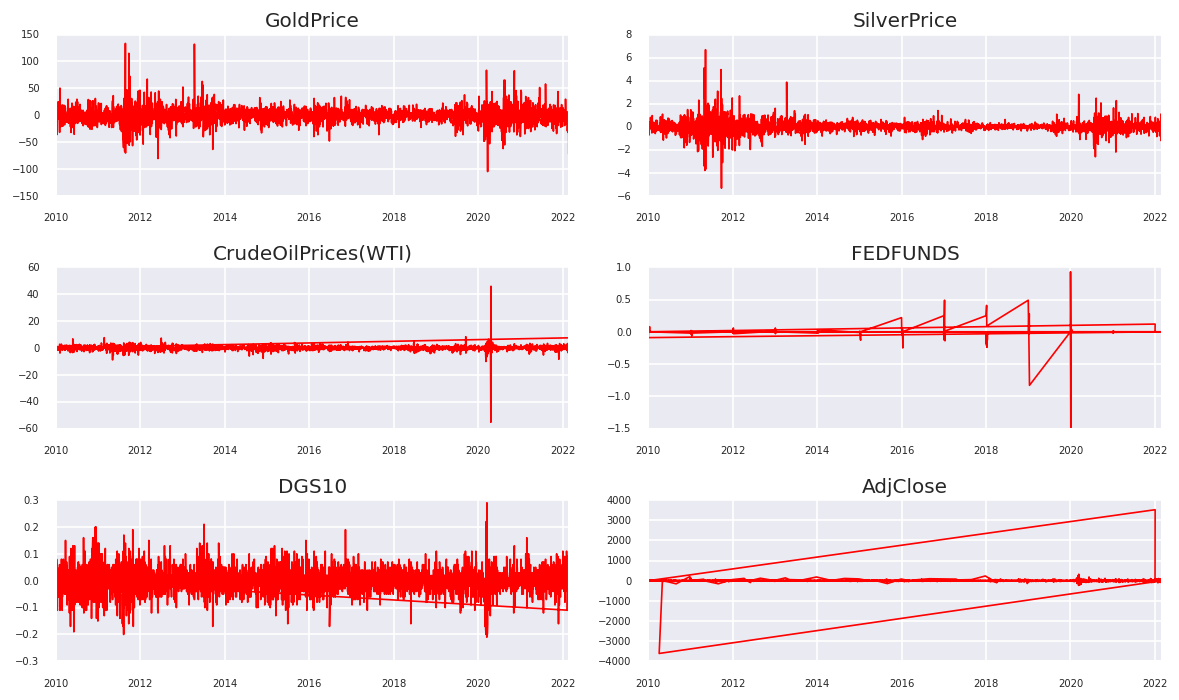

In [130]:
fig, axes = plt.subplots(nrows=3, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    d = transform_data[transform_data.columns[i]]
    ax.plot(d, color='red', linewidth=1)
    # Decorations
    ax.set_title(dataset.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines['top'].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

### Granger’s Causality Test: ###


The formal definition of Granger causality can be explained as, whether past values of x aid in the prediction of yt, conditional on having already accounted for the effects on yt of past values of y (and perhaps of past values of other variables). If they do, the x is said to “Granger cause” y. So, the basis behind VAR is that each of the time series in the system influences each other.
Granger’s causality Tests the null hypothesis that the coefficients of past values in the regression equation is zero. So, if the p-value obtained from the test is lesser than the significance level of 0.05, then, you can safely reject the null hypothesis. This has been performed on original data-set.

In [131]:
import statsmodels.tsa.stattools as sm
maxlag=12
test = 'ssr-chi2test'
def grangers_causality_matrix(X_train, variables, test = 'ssr_chi2test', verbose=False):
    dataset = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in dataset.columns:
        for r in dataset.index:
            test_result = sm.grangercausalitytests(X_train[[r,c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            dataset.loc[r,c] = min_p_value
    dataset.columns = [var + '_x' for var in variables]
    dataset.index = [var + '_y' for var in variables]
    return dataset



In [132]:
grangers_causality_matrix(dataset, variables = dataset.columns)
## https://rishi-a.github.io/2020/05/25/granger-causality.html
## https://towardsdatascience.com/granger-causality-and-vector-auto-regressive-model-for-time-series-forecasting-3226a64889a6

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 2, but rank is 1
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 3, but rank is 1
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 4, but rank is 1
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1894: ValueWarning: cov

GoldPrice_x  SilverPrice_x  CrudeOilPrices(WTI)_x  \
GoldPrice_y                 1.0000         0.0000                 0.8798   
SilverPrice_y               0.0000         1.0000                 0.8633   
CrudeOilPrices(WTI)_y       0.7162         0.8172                 1.0000   
FEDFUNDS_y                  0.1897         0.7421                 0.8920   
DGS10_y                     0.4305         0.6268                 0.0727   
AdjClose_y                  0.1575         0.0694                 0.0116   

                       FEDFUNDS_x  DGS10_x  AdjClose_x  
GoldPrice_y                0.5070   0.5927      0.3872  
SilverPrice_y              0.3898   0.5547      0.5560  
CrudeOilPrices(WTI)_y      0.8492   0.0568      0.0254  
FEDFUNDS_y                 1.0000   0.6205      0.6690  
DGS10_y                    0.6758   1.0000      0.0025  
AdjClose_y                 0.0000   0.0000      1.0000

The row are the response (y) and the columns are the predictor series (x).
* If we take the value 0.0000 in (row 1, column 5), it refers to the p-value of the Granger’s Causality test for InterestRate_x causing Gold_y. The 0.0000 in (row 5, column 1) refers to the p-value of InterestRate_y causing GoldPrice_x and so on.
* We can see that, in the case of Interest and USD variables, we cannot reject null hypothesis e.g. USD & Silver, USD & Oil.
* Our variables of interest are Gold and Oil here. So, for Gold, all the variables cause but for USD doesn’t causes any effect on Oil.

So, looking at the p-Values, we can assume that, except USD, all the other variables (time series) in the system are interchangeably causing each other. This justifies the VAR modeling approach for this system of multi time-series to forecast.

### VAR model ###

VAR requires stationarity of the series which means the mean to the series do not change over time (we can find this out from the plot drawn next to Augmented Dickey-Fuller Test).


So, I will fit the VAR model on training set and then used the fitted model to forecast the next 15 observations. These forecasts will be compared against the actual present in test data. I have taken the maximum lag (15) to identify the required lags for VAR model.

In [133]:
import numpy as np
import pandas
import statsmodels.api as sm
from statsmodels.tsa.api import VAR

mod = VAR(transform_data)
res = mod.fit(maxlags=15, ic='aic')
print(res.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 22, Oct, 2024
Time:                     19:59:24
--------------------------------------------------------------------
No. of Equations:         6.00000    BIC:                   -5.41028
Nobs:                     9499.00    HQIC:                  -5.68213
Log likelihood:          -52674.4    FPE:                 0.00296234
AIC:                     -5.82178    Det(Omega_mle):      0.00279763
--------------------------------------------------------------------
Results for equation GoldPrice
                             coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------------------
const                          -0.075846         0.083855           -0.904           0.366
L1.GoldPrice                    0.090573         0.014169            6.392           0.000
L1.SilverPrice  

### Residual plot ###

Residual plot looks normal with constant mean throughout apart from some large fluctuation during 2009, 2011, 2014 etc.

In [134]:
y_fitted = res.fittedvalues
y_fitted

Output hidden; open in https://colab.research.google.com to view.

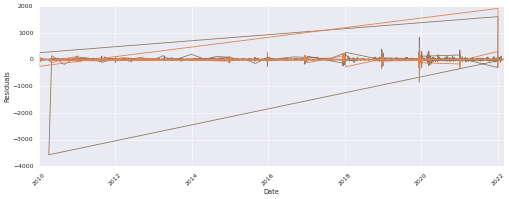

In [135]:
y_fitted = res.fittedvalues
residuals = res.resid
plt.figure(figsize = (15,5))
plt.plot(residuals, label='resid')
plt.plot(y_fitted, label='VAR prediction')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.ylabel('Residuals')
plt.grid(True)

### Durbin-Watson Statistic ###
The Durbin-Watson statistic will always have a value between 0 and 4. A value of 2.0 means that there is no auto-correlation detected in the sample. Values from 0 to less than 2 indicate positive auto-correlation and values from 2 to 4 indicate negative auto-correlation. A rule of thumb is that test statistic values in the range of 1.5 to 2.5 are relatively normal. Any value outside this range could be a cause for concern.

###### A stock price displaying positive auto-correlation would indicate that the price yesterday has a positive correlation on the price today — so if the stock fell yesterday, it is also likely that it falls today. A stock that has a negative auto-correlation, on the other hand, has a negative influence on itself over time — so that if it fell yesterday, there is a greater likelihood it will rise today. ######

In [136]:
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(res.resid)
for col,val in zip(transform_data.columns, out):
    print((col), ":", round(val,2))


GoldPrice : 2.0
SilverPrice : 2.0
CrudeOilPrices(WTI) : 2.0
FEDFUNDS : 2.0
DGS10 : 2.0
AdjClose : 2.01


#### There is no auto-correlation (2.0) exist; so, we can proceed with the forecast. ####

#### Prediction: ####
In order to forecast, the VAR model expects up to the lag order number of observations from the past data. This is because, the terms in the VAR model are essentially the lags of the various time series in the data-set, so we need to provide as many of the previous values as indicated by the lag order used by the model.

In [137]:
# Get the lag order
lag_order = res.k_ar
print(lag_order)
# Input data for forecasting
input_data = transform_data.values[-lag_order:]
print(input_data)
# forecasting
pred = res.forecast(y=input_data, steps=n_obs)
pred = (pd.DataFrame(pred, index=X_test.index, columns=X_test.columns + '_pred'))
print(pred)

15
[[   0.      0.      0.      0.      0.     90.85]
 [   0.      0.      0.      0.      0.     -8.15]
 [   0.      0.      0.      0.      0.     33.87]
 [   0.      0.      0.      0.      0.   -142.31]
 [   0.      0.      0.      0.      0.     84.32]
 [   0.      0.      0.      0.      0.    -19.45]
 [   0.      0.      0.      0.      0.     44.38]
 [   0.      0.      0.      0.      0.     98.95]
 [   0.      0.      0.      0.      0.     88.5 ]
 [   0.      0.      0.      0.      0.     80.13]
 [   0.      0.      0.      0.      0.     39.32]
 [   0.      0.      0.      0.      0.     55.91]
 [   0.      0.      0.      0.      0.    236.26]
 [   0.      0.      0.      0.      0.    -98.62]
 [   0.      0.      0.      0.      0.     90.75]]
            GoldPrice_pred  SilverPrice_pred  CrudeOilPrices(WTI)_pred  \
Date                                                                     
2018-08-27       -1.320655         -0.013344                  0.002077   
2018-12-2

In [138]:
print(X_test.index)

DatetimeIndex(['2018-08-27', '2018-12-26', '2019-04-22', '2019-05-06',
               '2019-08-26', '2019-12-26', '2020-04-13', '2020-05-08',
               '2020-08-31', '2020-12-28', '2021-04-05', '2021-05-03',
               '2021-08-30', '2021-12-27', '2021-12-28'],
              dtype='datetime64[ns]', name='Date', freq=None)


#### Invert the transformation: ####

The forecasts are generated but it is on the scale of the training data used by the model. So, to bring it back up to its original scale, we need to de-difference it.
The way to convert the differencing is to add these differences consecutively to the base number. An easy way to do it is to first determine the cumulative sum at index and then add it to the base number.
This process can be reversed by adding the observation at the prior time step to the difference value. inverted(ts) = differenced(ts) + observation(ts-1)

In [139]:
# inverting transformation
def invert_transformation(X_train, pred):
    forecast = pred.copy()
    columns = X_train.columns
    for col in columns:
        forecast[str(col)+'_pred'] = X_train[col].iloc[-1] + forecast[str(col)+'_pred'].cumsum()
        return forecast

output = invert_transformation(X_train, pred)

## https://stackoverflow.com/questions/20461165/how-to-convert-index-of-a-pandas-dataframe-into-a-column
output['Date'] = output.index

print(output)

            GoldPrice_pred  SilverPrice_pred  CrudeOilPrices(WTI)_pred  \
Date                                                                     
2018-08-27     1111.679345         -0.013344                  0.002077   
2018-12-26     1112.454261         -0.003338                  0.000966   
2019-04-22     1111.637840          0.005644                  0.002837   
2019-05-06     1111.626706         -0.009839                  0.001422   
2019-08-26     1111.472058          0.001441                  0.002012   
2019-12-26     1111.018293         -0.007654                  0.002385   
2020-04-13     1111.726092          0.015651                  0.002213   
2020-05-08     1110.859103         -0.010328                  0.002244   
2020-08-31     1111.667414          0.011851                  0.002800   
2020-12-28     1111.413227         -0.001334                  0.002260   
2021-04-05     1111.275004          0.000673                  0.002038   
2021-05-03     1111.547627         -0.

In [140]:
output.columns

Index(['GoldPrice_pred', 'SilverPrice_pred', 'CrudeOilPrices(WTI)_pred',
       'FEDFUNDS_pred', 'DGS10_pred', 'AdjClose_pred', 'Date'],
      dtype='object')

In [141]:
output.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 15 entries, 2018-08-27 to 2021-12-28
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   GoldPrice_pred            15 non-null     float64       
 1   SilverPrice_pred          15 non-null     float64       
 2   CrudeOilPrices(WTI)_pred  15 non-null     float64       
 3   FEDFUNDS_pred             15 non-null     float64       
 4   DGS10_pred                15 non-null     float64       
 5   AdjClose_pred             15 non-null     float64       
 6   Date                      15 non-null     datetime64[ns]
dtypes: datetime64[ns](1), float64(6)
memory usage: 960.0 bytes


In [142]:
print(output['GoldPrice_pred'])

Date
2018-08-27    1111.679345
2018-12-26    1112.454261
2019-04-22    1111.637840
2019-05-06    1111.626706
2019-08-26    1111.472058
2019-12-26    1111.018293
2020-04-13    1111.726092
2020-05-08    1110.859103
2020-08-31    1111.667414
2020-12-28    1111.413227
2021-04-05    1111.275004
2021-05-03    1111.547627
2021-08-30    1111.403590
2021-12-27    1111.366373
2021-12-28    1111.291476
Name: GoldPrice_pred, dtype: float64


In [143]:
output

GoldPrice_pred  SilverPrice_pred  CrudeOilPrices(WTI)_pred  \
Date                                                                     
2018-08-27     1111.679345         -0.013344                  0.002077   
2018-12-26     1112.454261         -0.003338                  0.000966   
2019-04-22     1111.637840          0.005644                  0.002837   
2019-05-06     1111.626706         -0.009839                  0.001422   
2019-08-26     1111.472058          0.001441                  0.002012   
2019-12-26     1111.018293         -0.007654                  0.002385   
2020-04-13     1111.726092          0.015651                  0.002213   
2020-05-08     1110.859103         -0.010328                  0.002244   
2020-08-31     1111.667414          0.011851                  0.002800   
2020-12-28     1111.413227         -0.001334                  0.002260   
2021-04-05     1111.275004          0.000673                  0.002038   
2021-05-03     1111.547627         -0.000331                  0.002742   
2021-08-30     1111.403590          0.004710                  0.002349   
2021-12-27     1111.366373         -0.002787                  0.002102   
2021-12-28     1111.291476         -0.000307                  0.002352   

            FEDFUNDS_pred  DGS10_pred  AdjClose_pred       Date  
Date                                                             
2018-08-27       0.002469   -0.002916      -1.410969 2018-08-27  
2018-12-26      -0.004566    0.000137       9.462783 2018-12-26  
2019-04-22       0.002148   -0.001546      -5.979443 2019-04-22  
2019-05-06      -0.003453   -0.000859       1.042819 2019-05-06  
2019-08-26       0.001318   -0.001559       6.754949 2019-08-26  
2019-12-26      -0.001579   -0.004247       1.241815 2019-12-26  
2020-04-13       0.000684    0.001572      -1.796052 2020-04-13  
2020-05-08      -0.000007   -0.004973      -2.692289 2020-05-08  
2020-08-31       0.000387   -0.002018       5.008024 2020-08-31  
2020-12-28       0.000981   -0.000482       0.129933 2020-12-28  
2021-04-05      -0.000697   -0.000831      -2.870856 2021-04-05  
2021-05-03       0.001205   -0.002761      -3.831930 2021-05-03  
2021-08-30       0.000127   -0.001044       3.322495 2021-08-30  
2021-12-27       0.000494    0.000033      -4.151265 2021-12-27  
2021-12-28       0.000099   -0.000774       3.571546 2021-12-28

In [144]:
#combining predicted and real data set
combine = pd.concat([output['GoldPrice_pred'], X_test['GoldPrice']], axis=1)
combine['accuracy'] = round(combine.apply(lambda row: row.GoldPrice_pred /row.GoldPrice *100, axis = 1),2)
combine['accuracy'] = pd.Series(["{0:.2f}%".format(val) for val in combine['accuracy']],index = combine.index)
combine = combine.round(decimals=2)
combine = combine.reset_index()
combine = combine.sort_values(by='Date', ascending=False)

print(combine)

         Date  GoldPrice_pred  GoldPrice accuracy
14 2021-12-28         1111.29     1113.0   99.85%
13 2021-12-27         1111.37     1113.0   99.85%
12 2021-08-30         1111.40     1113.0   99.86%
11 2021-05-03         1111.55     1113.0   99.87%
10 2021-04-05         1111.28     1113.0   99.85%
9  2020-12-28         1111.41     1113.0   99.86%
8  2020-08-31         1111.67     1113.0   99.88%
7  2020-05-08         1110.86     1113.0   99.81%
6  2020-04-13         1111.73     1113.0   99.89%
5  2019-12-26         1111.02     1113.0   99.82%
4  2019-08-26         1111.47     1113.0   99.86%
3  2019-05-06         1111.63     1113.0   99.88%
2  2019-04-22         1111.64     1113.0   99.88%
1  2018-12-26         1112.45     1113.0   99.95%
0  2018-08-27         1111.68     1113.0   99.88%


In [145]:
# old
#combining predicted and real data set
combine = pd.concat([output['GoldPrice_pred'], X_test['GoldPrice']], axis=1)
combine['accuracy'] = round(combine.apply(lambda row: row.GoldPrice_pred /row.GoldPrice *100, axis = 1),2)
combine['accuracy'] = pd.Series(["{0:.2f}%".format(val) for val in combine['accuracy']],index = combine.index)
combine = combine.round(decimals=2)
combine = combine.reset_index()
combine = combine.sort_values(by='Date', ascending=False)

print(combine)

         Date  GoldPrice_pred  GoldPrice accuracy
14 2021-12-28         1111.29     1113.0   99.85%
13 2021-12-27         1111.37     1113.0   99.85%
12 2021-08-30         1111.40     1113.0   99.86%
11 2021-05-03         1111.55     1113.0   99.87%
10 2021-04-05         1111.28     1113.0   99.85%
9  2020-12-28         1111.41     1113.0   99.86%
8  2020-08-31         1111.67     1113.0   99.88%
7  2020-05-08         1110.86     1113.0   99.81%
6  2020-04-13         1111.73     1113.0   99.89%
5  2019-12-26         1111.02     1113.0   99.82%
4  2019-08-26         1111.47     1113.0   99.86%
3  2019-05-06         1111.63     1113.0   99.88%
2  2019-04-22         1111.64     1113.0   99.88%
1  2018-12-26         1112.45     1113.0   99.95%
0  2018-08-27         1111.68     1113.0   99.88%


#### Evaluation: ####
To evaluate the forecasts, a comprehensive set of metrics, such as the MAPE, ME, MAE, MPE and RMSE can be computed. We have computed some of these as below.

In [146]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import math
#Forecast bias
forecast_errors = [combine['GoldPrice'][i]- combine['GoldPrice_pred'][i] for i in range(len(combine['GoldPrice']))]
bias = sum(forecast_errors) * 1.0/len(combine['GoldPrice'])

print('Bias: %f' % bias)
print('Mean absolute error:', mean_absolute_error(combine['GoldPrice'].values, combine['GoldPrice_pred'].values))
print('Mean squared error:', mean_squared_error(combine['GoldPrice'].values, combine['GoldPrice_pred'].values))
print('Root mean squared error:', math.sqrt(mean_squared_error(combine['GoldPrice'].values, combine['GoldPrice_pred'].values)))

Bias: 1.503333
Mean absolute error: 1.5033333333333152
Mean squared error: 2.3816066666666362
Root mean squared error: 1.5432454978604786


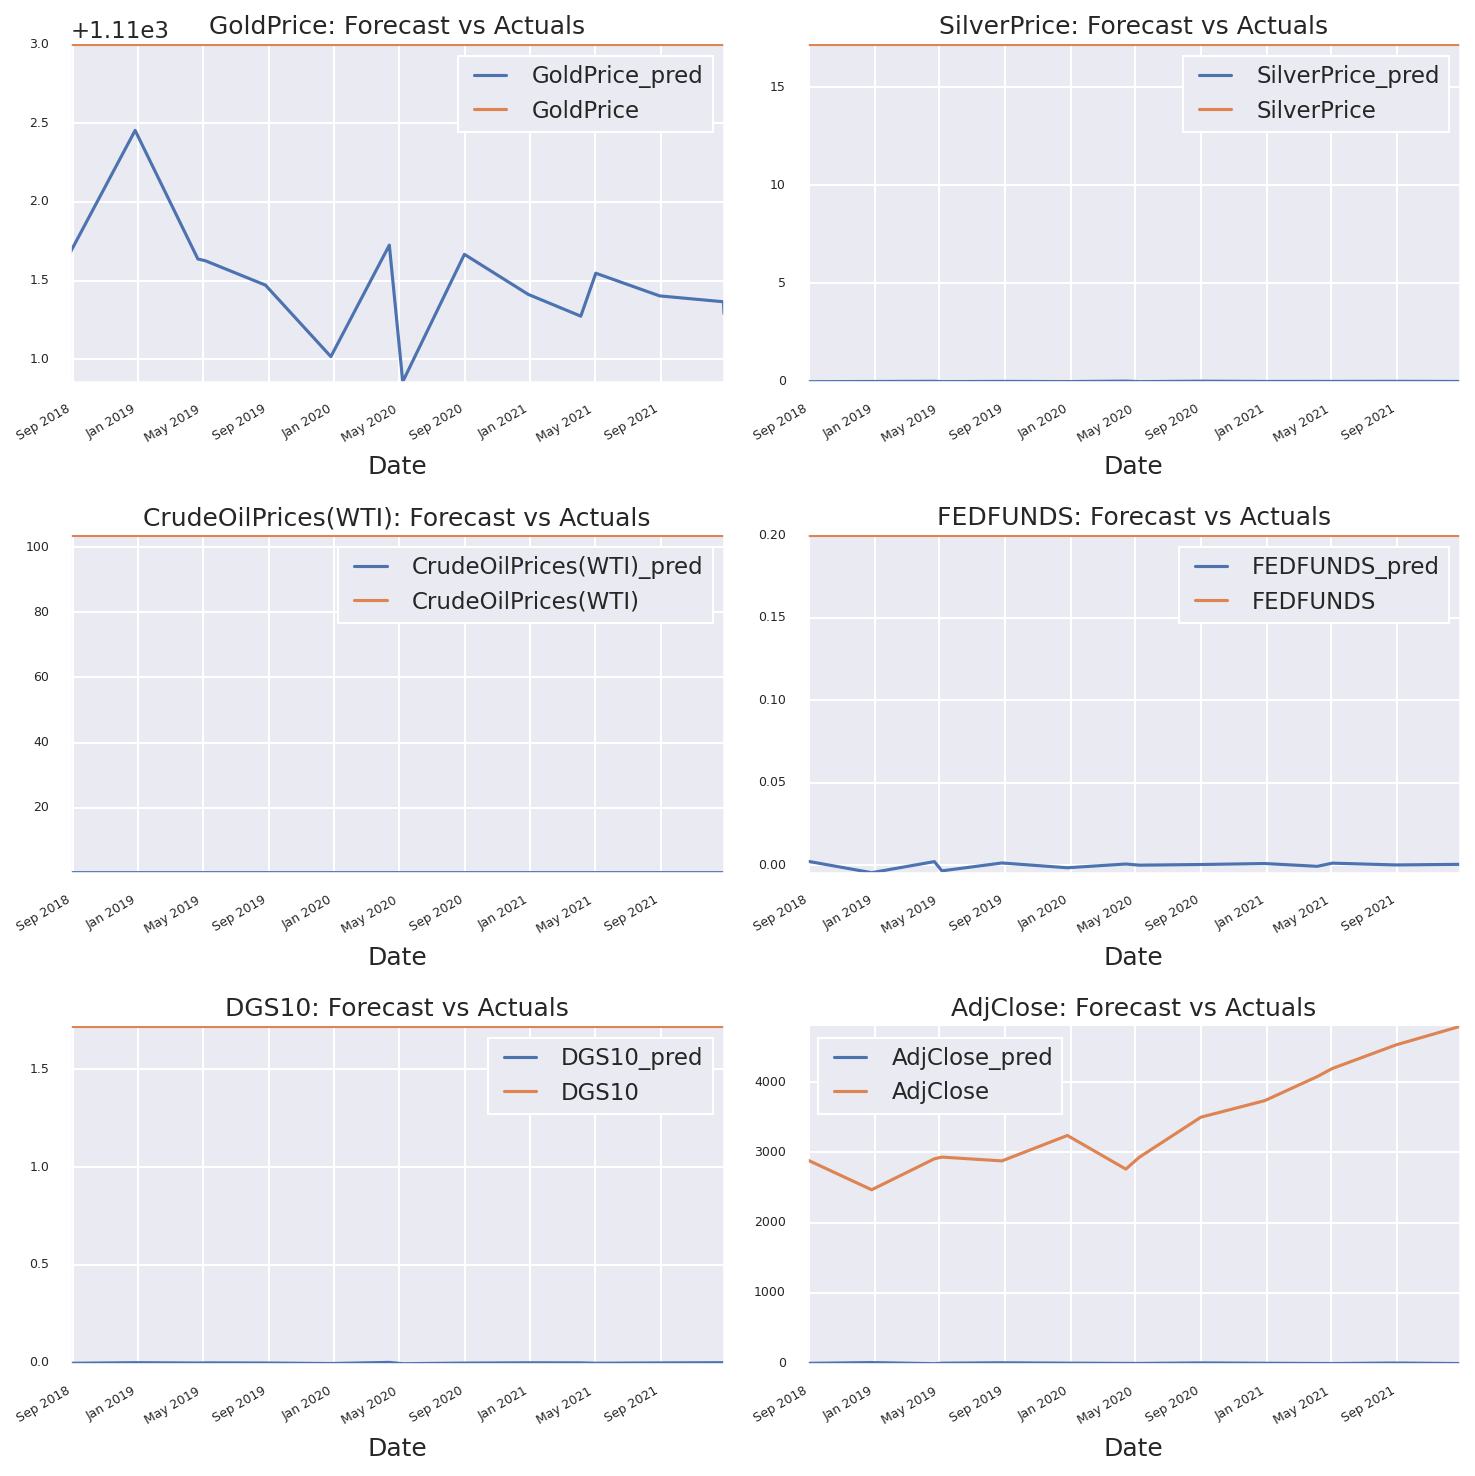

In [147]:
## https://www.machinelearningplus.com/time-series/vector-autoregression-examples-python/

fig, axes = plt.subplots(nrows=int(len(dataset.columns)/2), ncols=2, dpi=150, figsize=(10,10))
for i, (col,ax) in enumerate(zip(dataset.columns, axes.flatten())):
    output[col+'_pred'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    X_test[col][-n_obs:].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

#### Summary ####

The VAR model is a popular tool for the purpose of predicting joint dynamics of multiple time series based on linear functions of past observations. More analysis e.g. impulse response (IRF) and forecast error variance decomposition (FEVD) can also be done along-with VAR to for assessing the impacts of shock from one asset on another to assess the impacts of shock from one asset on another. However, I will keep this simple here for easy understanding. In real-life business case, we should do multiple models with different approach to do the comparative analysis before zeroed down on one or a hybrid model.


### Prophet In Action ###

In [148]:
# Time Series
# https://dev.socrata.com/blog/2019/10/07/time-series-analysis-with-jupyter-notebooks-and-socrata.html

# Data Source
# Building Permits
# https://data.seattle.gov/Permitting/Building-Permits/76t5-zqzr

dataset.info()
df3=dataset

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9530 entries, 2022-03-01 to 2021-12-28
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   GoldPrice            9530 non-null   float64
 1   SilverPrice          9530 non-null   float64
 2   CrudeOilPrices(WTI)  9530 non-null   float64
 3   FEDFUNDS             9530 non-null   float64
 4   DGS10                9530 non-null   float64
 5   AdjClose             9530 non-null   float64
dtypes: float64(6)
memory usage: 521.2 KB


In [149]:
dataset.index

DatetimeIndex(['2022-03-01', '2022-02-28', '2022-02-25', '2022-02-24',
               '2022-02-23', '2022-02-22', '2022-02-21', '2022-02-18',
               '2022-02-17', '2022-02-16',
               ...
               '2019-12-26', '2020-04-13', '2020-05-08', '2020-08-31',
               '2020-12-28', '2021-04-05', '2021-05-03', '2021-08-30',
               '2021-12-27', '2021-12-28'],
              dtype='datetime64[ns]', name='Date', length=9530, freq=None)

In [155]:
!pip install prophet

In [156]:
from prophet import Prophet
model = Prophet()
train_df = df3.rename(columns={"GoldPrice":'y'})
train_df["ds"] = train_df.index
model.fit(train_df)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfrgr_hi0/4qiz56h1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfrgr_hi0/ch28wtku.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=39115', 'data', 'file=/tmp/tmpfrgr_hi0/4qiz56h1.json', 'init=/tmp/tmpfrgr_hi0/ch28wtku.json', 'output', 'file=/tmp/tmpfrgr_hi0/prophet_model7kj1cexx/prophet_model-20241022202154.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:21:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:21:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


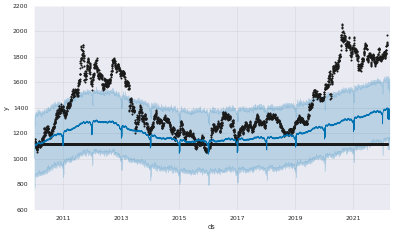

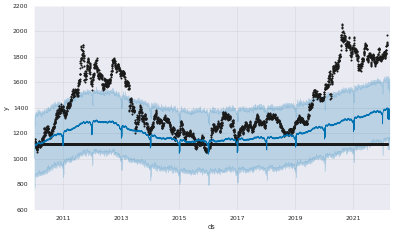

In [157]:
pd.plotting.register_matplotlib_converters()

# We want to forecast over the next 5 months
future = model.make_future_dataframe(30, freq='D', include_history=True)
forecast = model.predict(future)
model.plot(forecast)

In [158]:
forecast

Output hidden; open in https://colab.research.google.com to view.